# **[BASELINE]** FEATURE EXTRACTION AND CLASSIFICATION

In [1]:
attempt = "baseline"

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-07-28 17:46:46.624320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753724806.813662      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753724806.867790      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## **WITH DENOISING (PREPROCESSING)**

### Import Preprocessed Data

In [2]:
import os
import pickle
import numpy as np

path = '/kaggle/input/preprocessed-multiband/'
with open(os.path.join(path, 'preprocessed_multiband_eeg.pkl'), "rb") as f:
    data = pickle.load(f)

print(data.keys())
print(data['X']['delta'].shape)
print(data['y'].shape)

dict_keys(['X', 'y', 'augmented_indices', 'augmentation_methods', 'duplication_sources'])
(34230, 32, 125)
(34230,)


In [3]:
from keras.utils import to_categorical

X = np.stack([
    data['X']['delta'],
    data['X']['theta'],
    data['X']['alpha'],
    data['X']['beta']
], axis=1)
X = np.transpose(X, (0, 1, 3, 2))

y = to_categorical(data["y"], num_classes=10)

print(X.shape)
print(y.shape)

2025-07-29 03:47:00.546085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753760820.910673      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753760821.013193      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(34230, 4, 125, 32)
(34230, 10)


In [5]:
print(len(data['augmented_indices']))
print(len(data['augmentation_methods']))
print(len(data['duplication_sources']))

4230
4230
4230


In [8]:
not_augmented_flag = ["-1"] * 30000
all_idx = [i for i in range(30000)] + data['augmented_indices']
aug_met = not_augmented_flag + data['augmentation_methods']
dup_src = not_augmented_flag + data['duplication_sources']

print(len(all_idx))
print(len(aug_met))
print(len(dup_src))

34230
34230
34230


### **Define Topology**

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, Conv2D, Flatten, Dropout, LSTM, Bidirectional,
    GlobalAveragePooling1D, GlobalAveragePooling2D, Reshape, TimeDistributed,
    LayerNormalization, MultiHeadAttention, Add
)
from tensorflow.keras.regularizers import l1_l2

latent_dim = 100
num_classes = 10
regularizer = l1_l2(l1=1e-5, l2=1e-4)

In [5]:
from tensorflow.keras.metrics import Precision, Recall

def compile_model(model):
    model.compile (
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss      = 'categorical_crossentropy',
        metrics   = ['accuracy', Precision(), Recall()]
    )
    return model

#### ANN-MLP

In [6]:
def build_ann_mlp():
    inp = Input(shape=(4, 125, 32))
    x = Flatten()(inp)
    x = Dense(256, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizer)(x)

    latent = Dense(latent_dim, activation='tanh', name='latent_vector')(x)
    x = Dense(64, activation='relu')(latent)
    out = Dense(num_classes, activation='softmax', name='class_output')(x)

    return Model(inputs=inp, outputs=out, name='ANN_MLP')

#### CNN (2D)

In [7]:
def build_cnn():
    inp = Input(shape=(4, 125, 32))
    x = Reshape((4, 125, 32, 1))(inp)

    x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu', padding='same'))(inp)
    x = TimeDistributed(GlobalAveragePooling1D())(x)

    x = Flatten()(x)
    latent = Dense(latent_dim, activation='tanh', name='latent_vector')(x)
    x = Dense(64, activation='relu')(latent)
    out = Dense(num_classes, activation='softmax', name='class_output')(x)

    return Model(inputs=inp, outputs=out, name='CNN_1D')

#### LSTM

In [8]:
def build_lstm():
    inp = Input(shape=(4, 125, 32))
    x = TimeDistributed(Flatten())(inp)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(128, return_sequences=False)(x)
    
    latent = Dense(latent_dim, activation='tanh', name='latent_vector')(x)
    x = Dense(64, activation='relu')(latent)
    out = Dense(num_classes, activation='softmax', name='class_output')(x)

    return Model(inputs=inp, outputs=out, name='LSTM_Model')

#### BiLSTM

In [9]:
def build_bilstm():
    inp = Input(shape=(4, 125, 32))
    x = TimeDistributed(Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=regularizer)))(inp)
    x = Dropout(0.3)(x)

    x = GlobalAveragePooling1D()(x)

    latent = Dense(latent_dim, activation='tanh', name='latent_vector')(x)
    x = Dense(64, activation='relu')(latent)
    out = Dense(num_classes, activation='softmax', name='class_output')(x)

    return Model(inputs=inp, outputs=out, name='BiLSTM')

#### CNN + LSTM

In [10]:
def build_cnn_lstm():
    inp = Input(shape=(4, 125, 32))
    
    x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu', padding='same'))(inp)
    x = TimeDistributed(GlobalAveragePooling1D())(x)
    
    x = LSTM(128, return_sequences=False, kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x)

    latent = Dense(latent_dim, activation='tanh', name='latent_vector')(x)
    x = Dense(64, activation='relu')(latent)
    out = Dense(num_classes, activation='softmax', name='class_output')(x)

    return Model(inputs=inp, outputs=out, name='CNN_LSTM')

#### Transformer (Encoder-Only)

In [11]:
# --- Positional Encoding ---
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_len, d_model):
        super(PositionalEncoding, self).__init__()
        pos = np.arange(sequence_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        angle_rads = pos * angle_rates

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


# --- Transformer ---
def build_transformer_encoder():
    inp = Input(shape=(4, 125, 32))  # (bands, timesteps, channels)
    
    x = TimeDistributed(Flatten())(inp)  # (batch, 4, 4000)

    # === Add Positional Encoding ===
    x = PositionalEncoding(sequence_len=4, d_model=4000)(x)

    # === Encoder Block ===
    attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)

    ff = Dense(256, activation='relu')(x)
    ff = Dense(128)(ff)

    x = Dense(128)(x)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)

    latent = Dense(latent_dim, activation='tanh', name='latent_vector')(x)
    x = Dense(64, activation='relu')(latent)
    out = Dense(num_classes, activation='softmax', name='class_output')(x)

    return Model(inputs=inp, outputs=out, name='Transformer_Encoder')

#### LSTM + Attention

In [12]:
def build_lstm_attention():
    from tensorflow.keras.layers import (
        Input, LSTM, Dense, Dropout, Attention, LayerNormalization, Add,
        GlobalAveragePooling1D, TimeDistributed
    )
    from tensorflow.keras.models import Model
    from tensorflow.keras.regularizers import l1_l2

    latent_dim = 100
    num_classes = 10
    regularizer = l1_l2(l1=1e-5, l2=1e-4)

    # Input EEG: 4 bands, 125 timesteps, 32 channels
    inputs = Input(shape=(4, 125, 32))

    # === Step 1: SHARED BAND ENCODER ===
    def build_band_encoder():
        inp = Input(shape=(125, 32))
        x = LSTM(128, return_sequences=True, kernel_regularizer=regularizer)(inp)
        x = Dropout(0.4)(x)
        x = LSTM(128, return_sequences=True, kernel_regularizer=regularizer)(x)
        x = Dropout(0.4)(x)
        x = LSTM(128, return_sequences=True, kernel_regularizer=regularizer)(x)

        # Self-attention block (intra-band)
        attn = Attention()([x, x])
        attn = LayerNormalization()(Add()([x, attn]))

        global_feat = GlobalAveragePooling1D()(attn)
        return Model(inputs=inp, outputs=global_feat, name="band_encoder")

    band_encoder = build_band_encoder()

    # === Step 2: ENCODE ALL BANDS ===
    encoded_bands = TimeDistributed(band_encoder)(inputs)  # Shape: (batch, 4, 128)

    # === Step 3: INTER-BAND ATTENTION ===
    attn_inter = Attention()([encoded_bands, encoded_bands])
    attn_inter = LayerNormalization()(Add()([encoded_bands, attn_inter]))

    x = LSTM(128, return_sequences=False, kernel_regularizer=regularizer)(attn_inter)

    # === Step 4: LATENT + CLASSIFICATION ===
    latent_output = Dense(latent_dim, activation='tanh',
                          kernel_regularizer=regularizer,
                          name='latent_vector')(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizer)(latent_output)
    x = Dropout(0.4)(x)
    classifier_output = Dense(num_classes, activation='softmax',
                              kernel_regularizer=regularizer,
                              name='class_output')(x)

    return Model(inputs=inputs, outputs=classifier_output, name='LSTM_Attention')

### Training Start! With ALL Denoising (Preprocessing)

In [13]:
import matplotlib.pyplot as plt

def plot_loss(history, title='Training Progress'):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def make_callbacks():
    early_stop = EarlyStopping (
        monitor              = 'val_accuracy',       
        patience             = 15,               
        mode                 = 'max',
        verbose              = 0,
        restore_best_weights = True
    )
    
    model_checkpoint = ModelCheckpoint (
        f'best_LSTM_{attempt}.keras',
        monitor              = 'val_loss',
        save_best_only       = True,
        mode                 = 'min',
        verbose              = 0
    )
    
    reduce_lr = ReduceLROnPlateau (
        monitor              = 'val_loss',
        factor               = 0.5,
        patience             = 10,
        min_lr               = 1e-6,
        verbose              = 0
    )

    return (early_stop, model_checkpoint, reduce_lr)

In [15]:
def build_model(model_type):
    if model_type == 'ann_mlp':
        return build_ann_mlp()
    elif model_type == 'cnn':
        return build_cnn()
    elif model_type == 'lstm':
        return build_lstm()
    elif model_type == 'bilstm':
        return build_bilstm()
    elif model_type == 'cnn_lstm':
        return build_cnn_lstm()
    elif model_type == 'transformer_encoder':
        return build_transformer_encoder()
    elif model_type == 'lstm_attention':
        return build_lstm_attention()

Processing model:ann_mlp, seed:42, fold:0


I0000 00:00:1753725231.555389      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753725231.556142      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1753725240.215039     103 service.cc:148] XLA service 0x7f41fc0038b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753725240.215685     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753725240.215707     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753725240.535886     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753725242.397554     103 device_compiler.h:188] Compiled clust

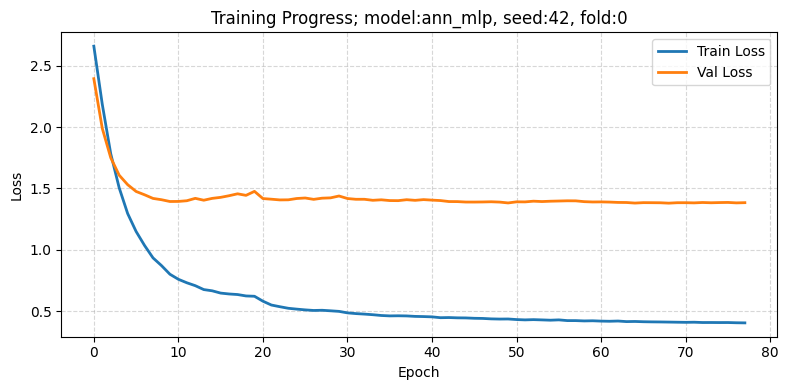

Processing model:ann_mlp, seed:42, fold:1


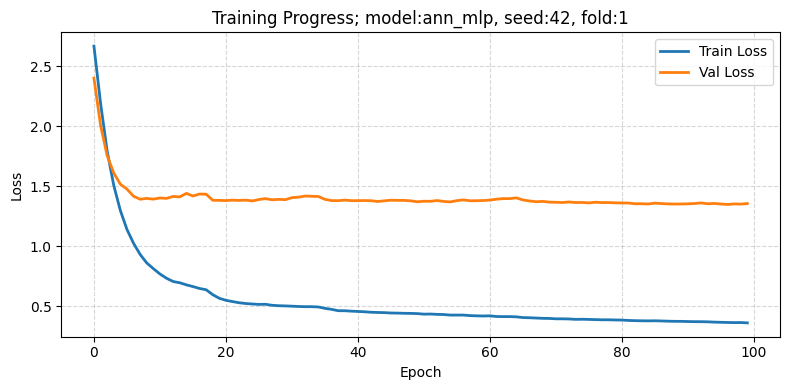

Processing model:ann_mlp, seed:42, fold:2


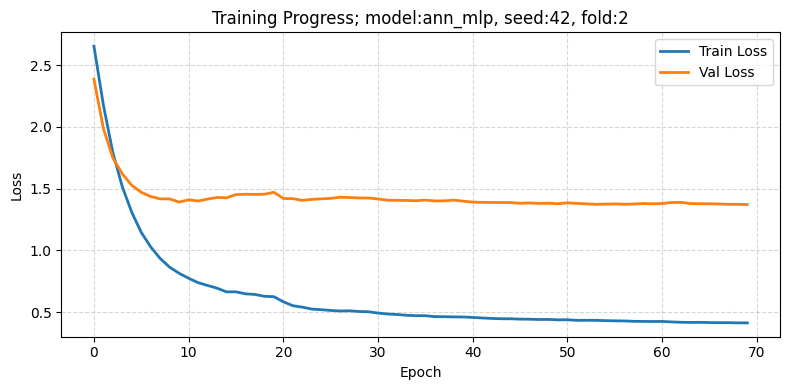

Processing model:ann_mlp, seed:140, fold:0


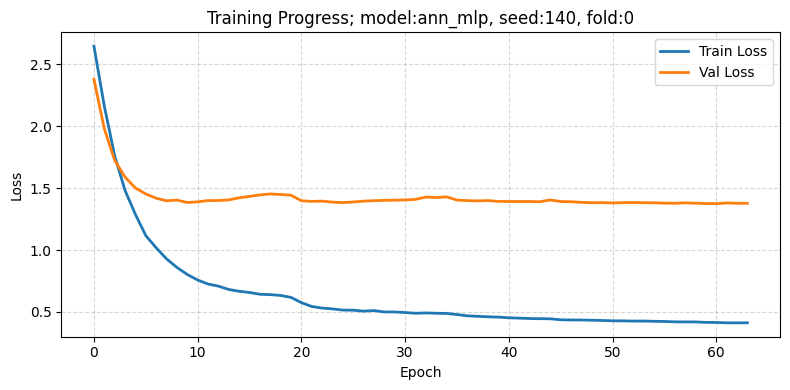

Processing model:ann_mlp, seed:140, fold:1


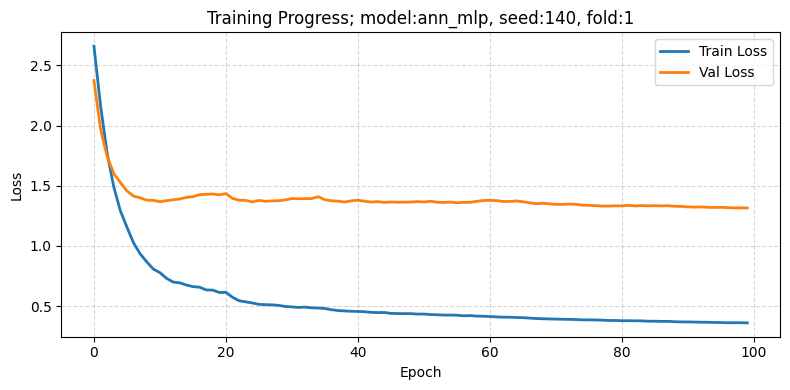

Processing model:ann_mlp, seed:140, fold:2


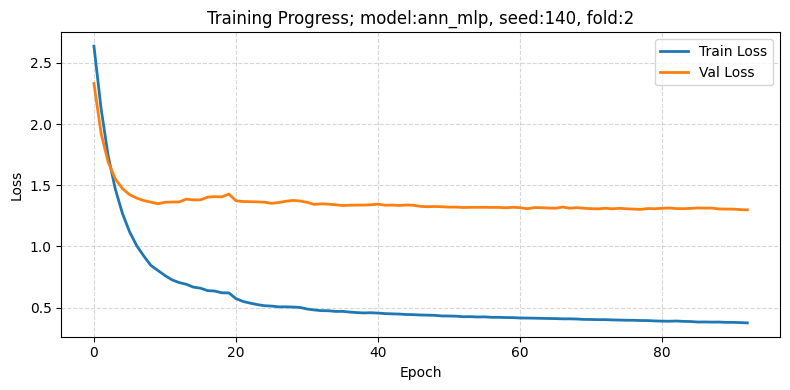

Processing model:ann_mlp, seed:2025, fold:0


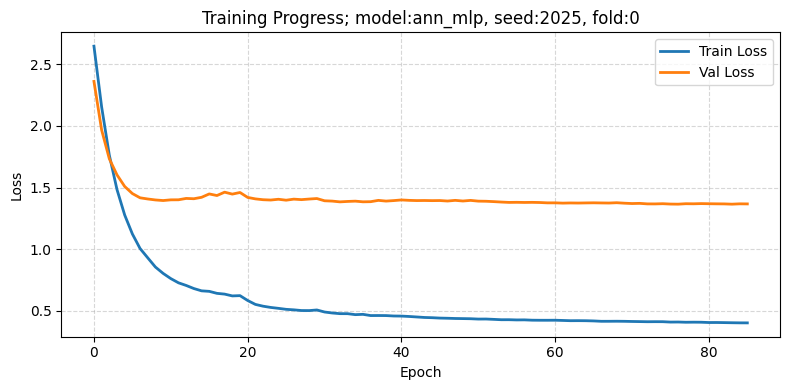

Processing model:ann_mlp, seed:2025, fold:1


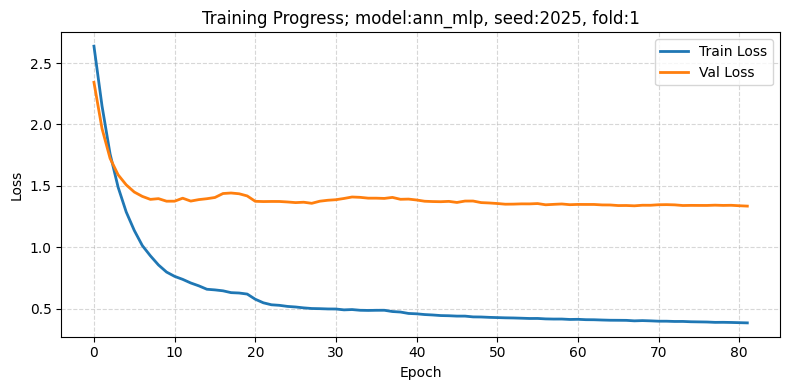

Processing model:ann_mlp, seed:2025, fold:2


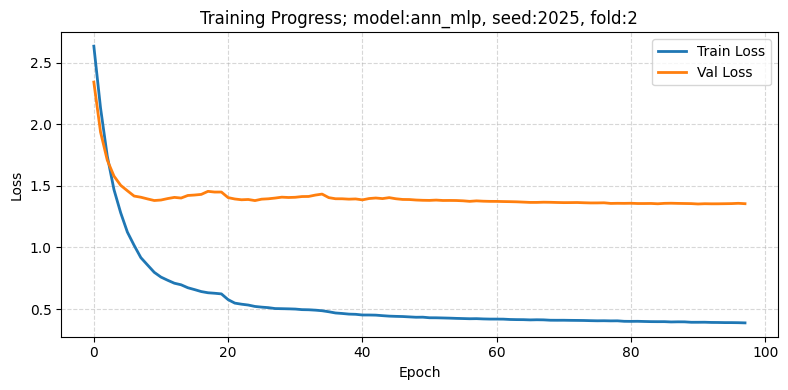

Processing model:cnn, seed:42, fold:0


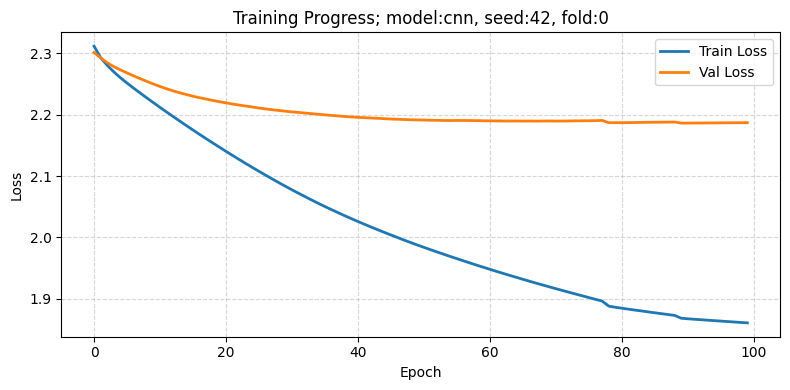

Processing model:cnn, seed:42, fold:1


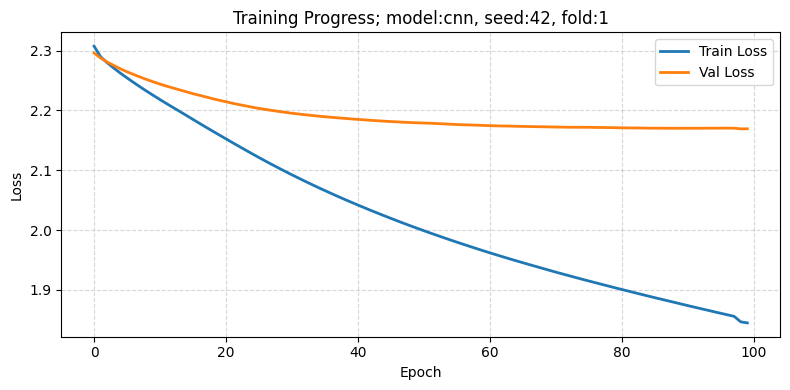

Processing model:cnn, seed:42, fold:2


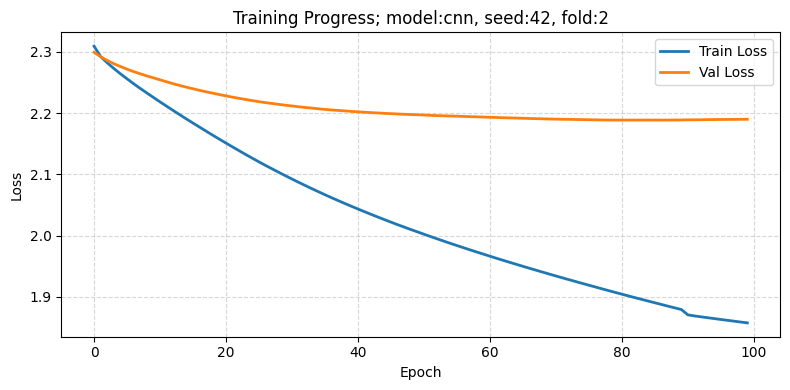

Processing model:cnn, seed:140, fold:0


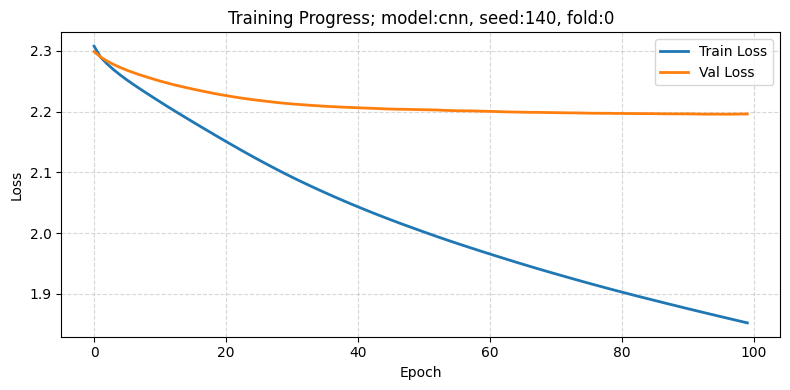

Processing model:cnn, seed:140, fold:1


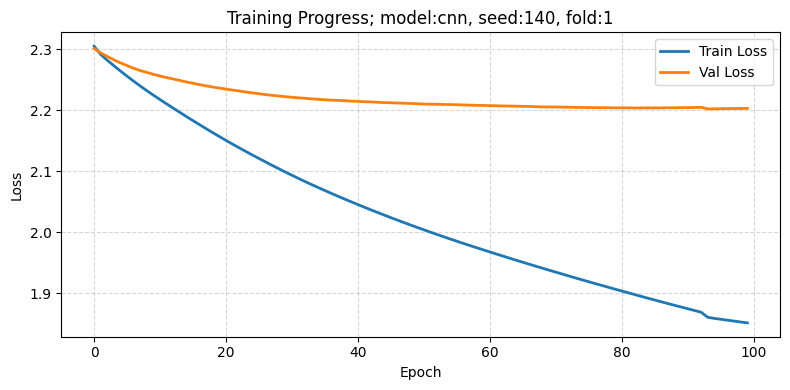

Processing model:cnn, seed:140, fold:2


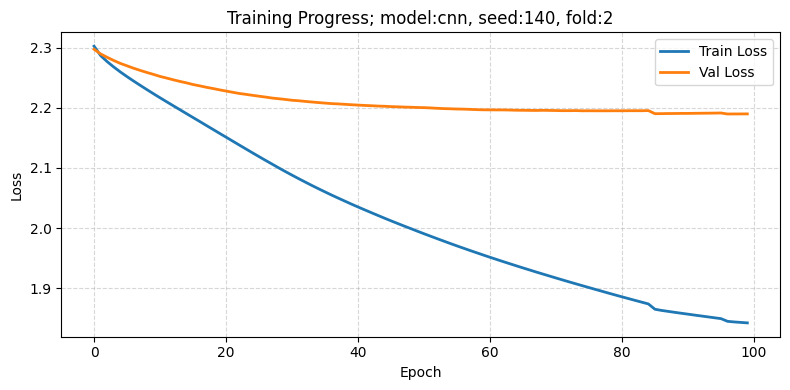

Processing model:cnn, seed:2025, fold:0


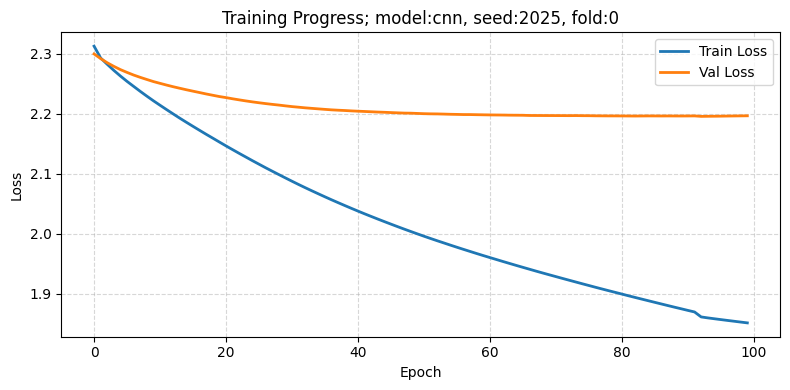

Processing model:cnn, seed:2025, fold:1


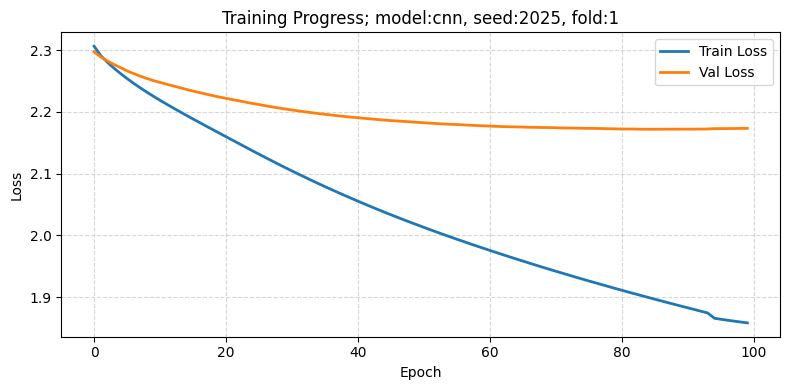

Processing model:cnn, seed:2025, fold:2


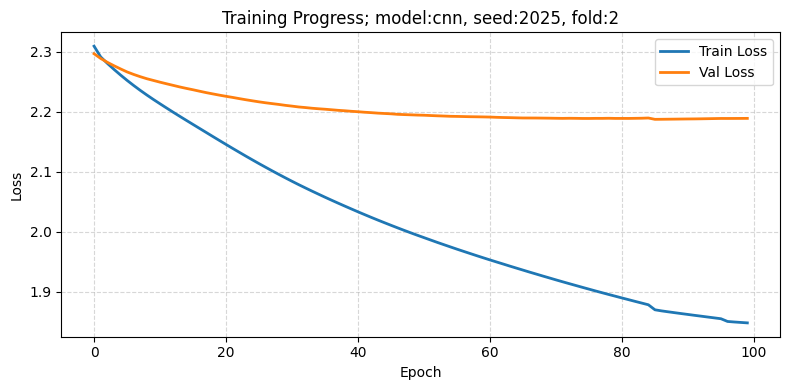

Processing model:lstm, seed:42, fold:0


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 10), output.shape=(None, 4, 10)

In [17]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import numpy as np

results = []

model_types = ['ann_mlp', 'cnn', 'lstm', 'bilstm', 'cnn_lstm', 'transformer_encoder', 'lstm_attention']
seeds = [42, 140, 2025]
n_folds = 3

for model_type in model_types:
    for seed in seeds:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

        y_int = np.argmax(y, axis=1)
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_int)):
            print(f"Processing model:{model_type}, seed:{seed}, fold:{fold}")
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Set seed reproducibility
            tf.random.set_seed(seed)
            np.random.seed(seed)

            # Build model
            model = compile_model(build_model(model_type))
            early_stop, model_checkpoint, reduce_lr = make_callbacks()

            # Callbacks
            history = model.fit(
                X_train, y_train,
                validation_data = (X_val, y_val),
                epochs          = 100,
                batch_size      = 128,
                callbacks       = [early_stop, model_checkpoint, reduce_lr],
                verbose         = 0
            )
            
            val_loss_history = history.history['val_loss']
            val_acc_history  = history.history['val_accuracy']
            
            # Final values
            final_val_loss = val_loss_history[-1]
            final_val_acc  = val_acc_history[-1]
            
            # Best loss and its corresponding accuracy
            best_val_loss_idx = np.argmin(val_loss_history)
            best_val_loss     = val_loss_history[best_val_loss_idx]
            acc_at_best_loss  = val_acc_history[best_val_loss_idx]
            
            # Best accuracy and its corresponding loss
            best_val_acc_idx  = np.argmax(val_acc_history)
            best_val_acc      = val_acc_history[best_val_acc_idx]
            loss_at_best_acc  = val_loss_history[best_val_acc_idx]
            
            results.append({
                'model': model_type,
                'seed': seed,
                'fold': fold,
                'final_loss': final_val_loss,
                'final_acc': final_val_acc,
                'best_loss': best_val_loss,
                'acc_at_best_loss': acc_at_best_loss,
                'best_acc': best_val_acc,
                'loss_at_best_acc': loss_at_best_acc,
                'history': history
            })
            plot_loss(history, title=f'Training Progress; model:{model_type}, seed:{seed}, fold:{fold}')

print("EXPERIMENT FINISHED.")

Processing model:lstm, seed:42, fold:0


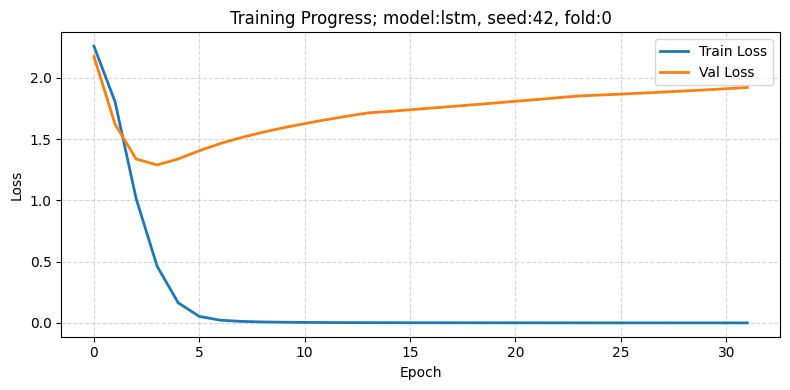

Processing model:lstm, seed:42, fold:1


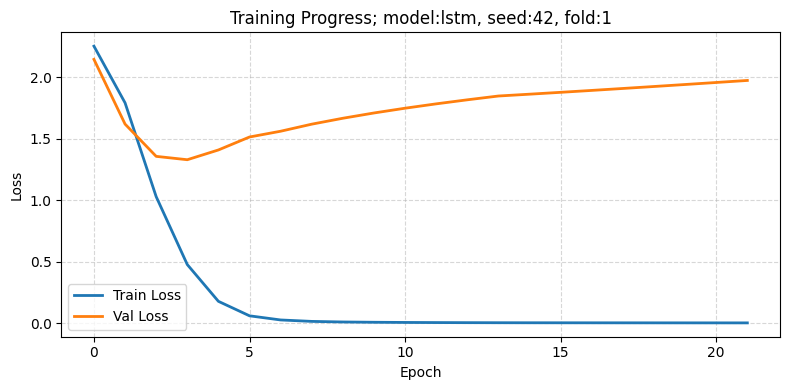

Processing model:lstm, seed:42, fold:2


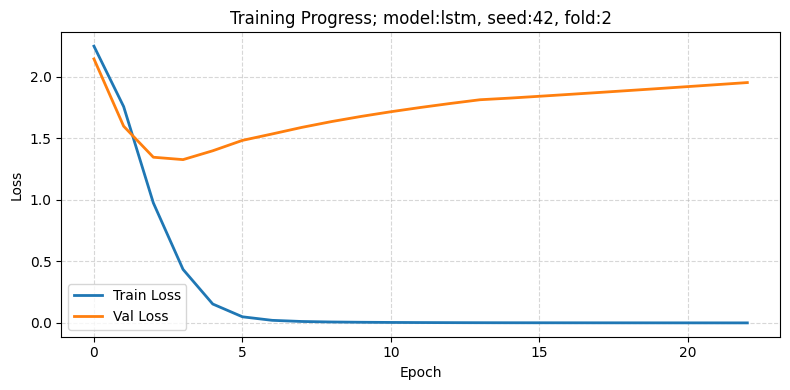

Processing model:lstm, seed:140, fold:0


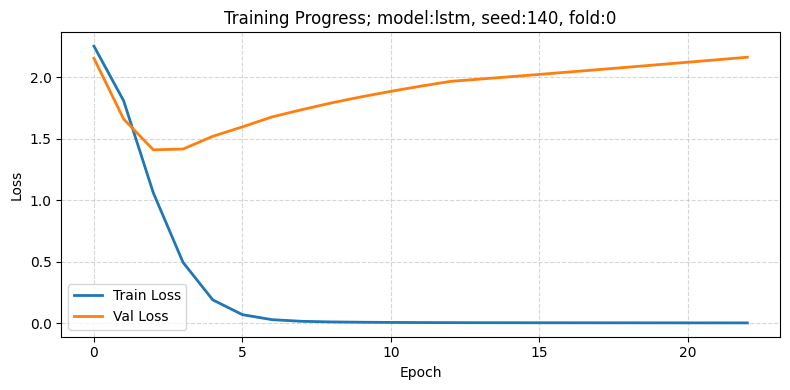

Processing model:lstm, seed:140, fold:1


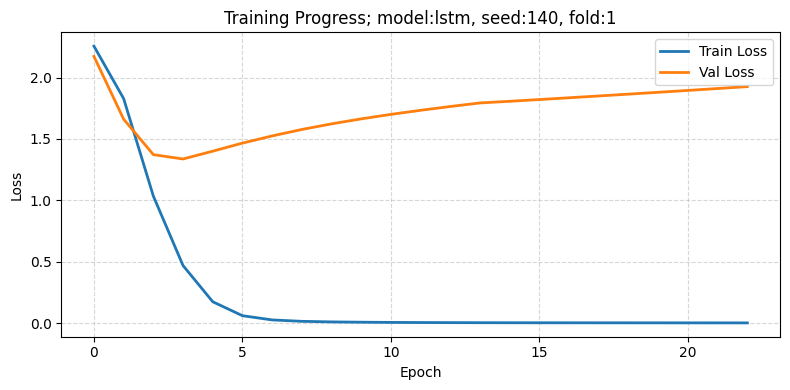

Processing model:lstm, seed:140, fold:2


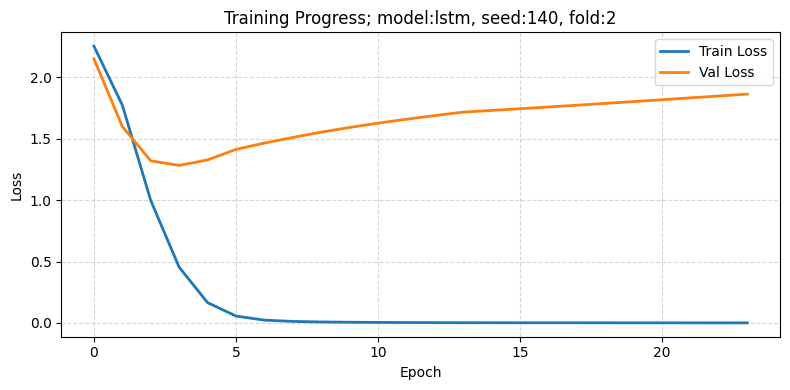

Processing model:lstm, seed:2025, fold:0


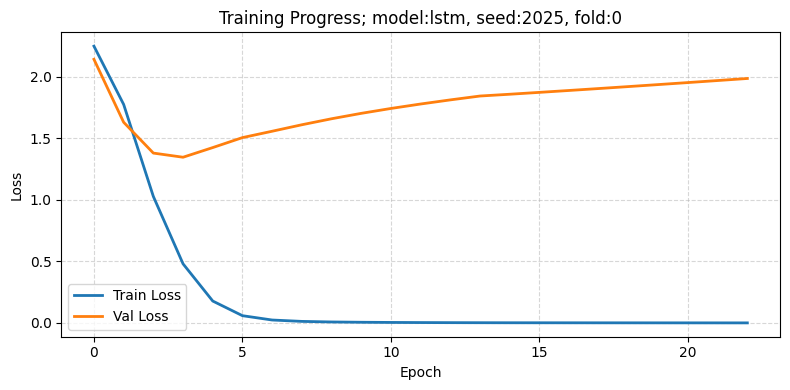

Processing model:lstm, seed:2025, fold:1


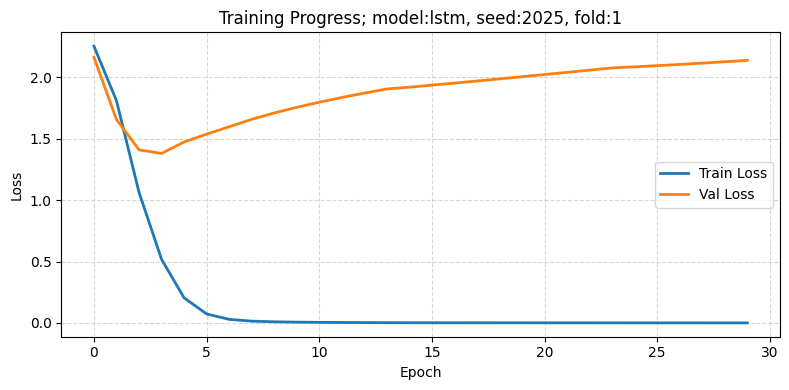

Processing model:lstm, seed:2025, fold:2


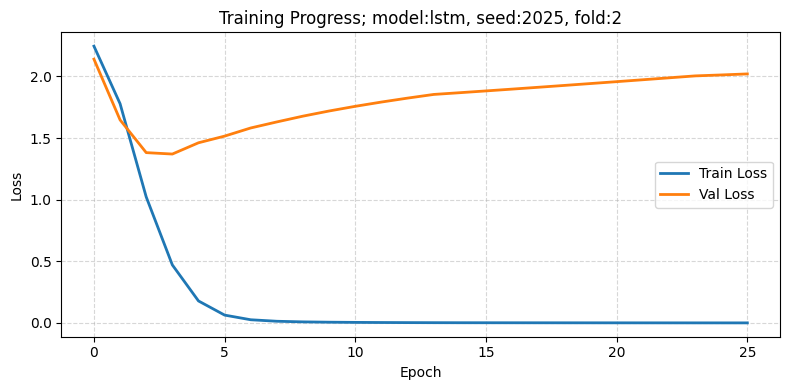

Processing model:bilstm, seed:42, fold:0


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 10), output.shape=(None, 4, 10)

Processing model:bilstm, seed:42, fold:0


I0000 00:00:1753760935.510885      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753760935.511547      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1753760949.043609     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


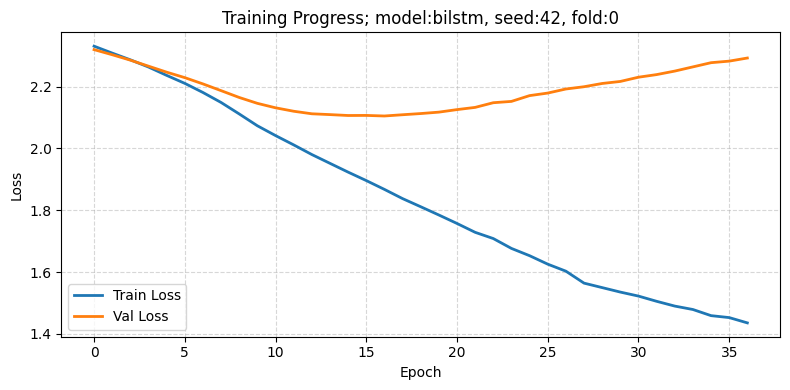

Processing model:bilstm, seed:42, fold:1


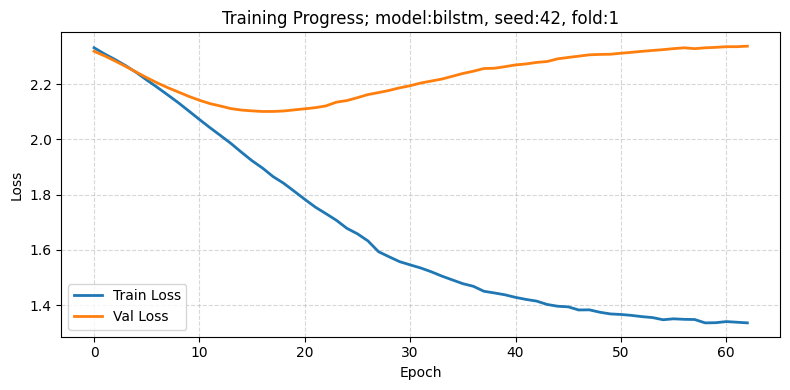

Processing model:bilstm, seed:42, fold:2


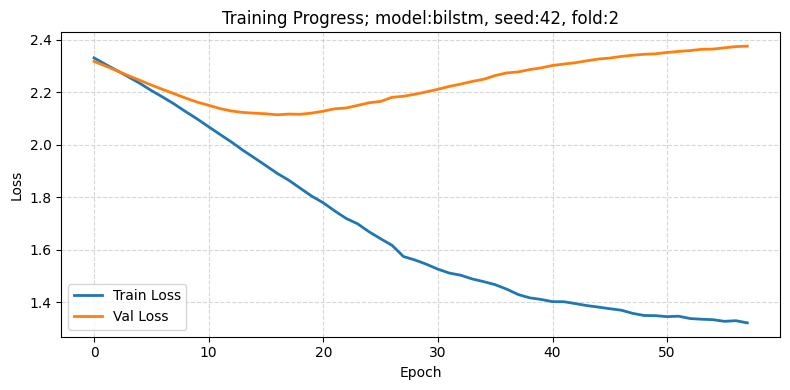

Processing model:bilstm, seed:140, fold:0


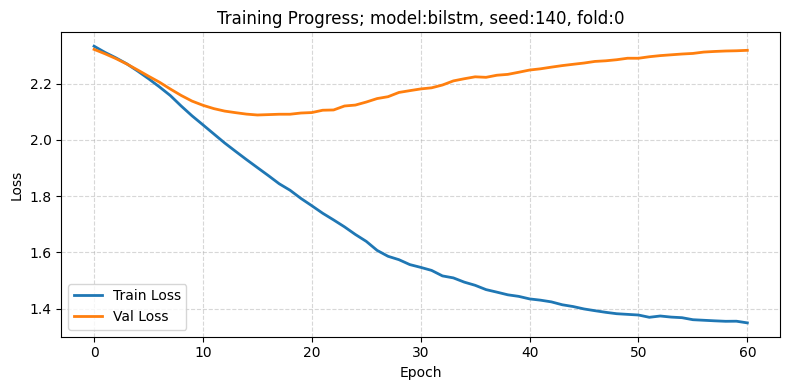

Processing model:bilstm, seed:140, fold:1


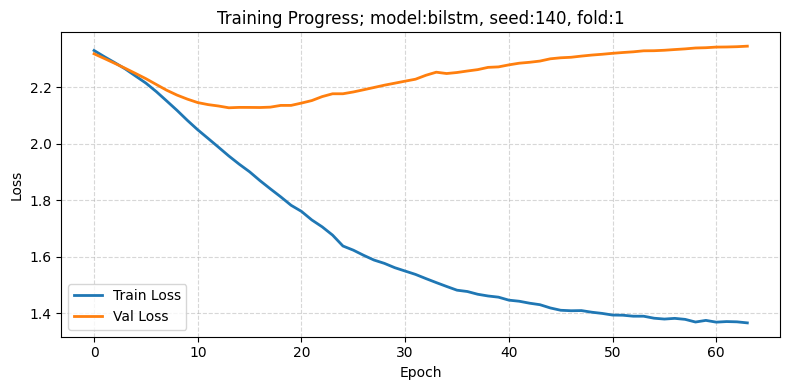

Processing model:bilstm, seed:140, fold:2


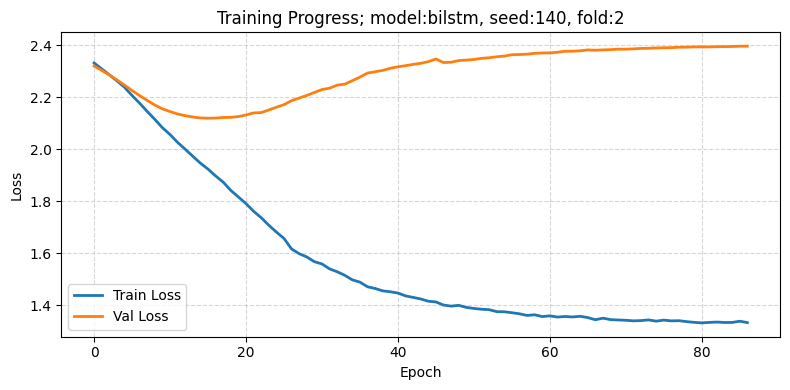

Processing model:bilstm, seed:2025, fold:0


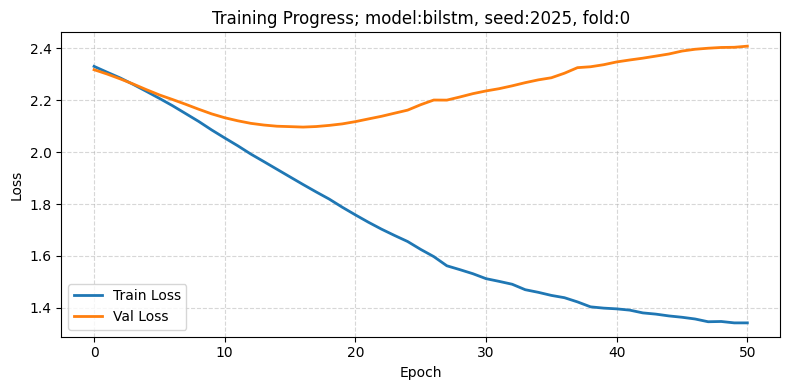

Processing model:bilstm, seed:2025, fold:1


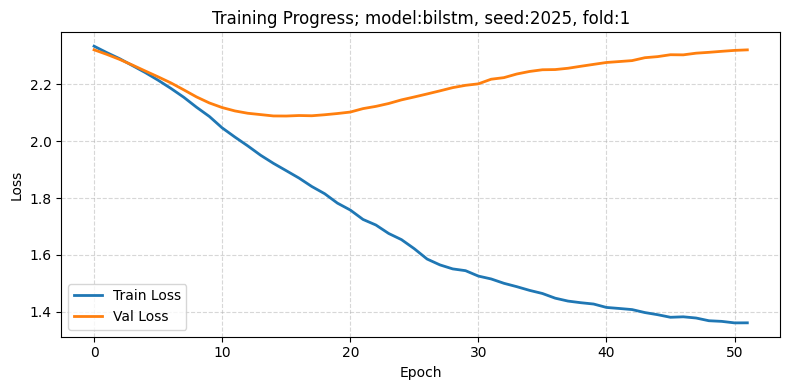

Processing model:bilstm, seed:2025, fold:2


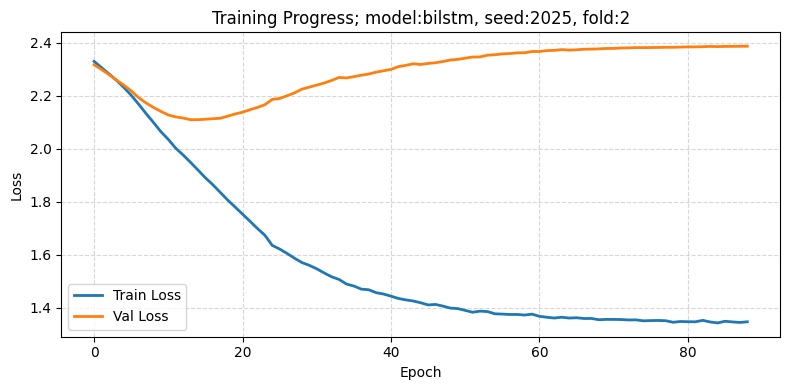

Processing model:cnn_lstm, seed:42, fold:0


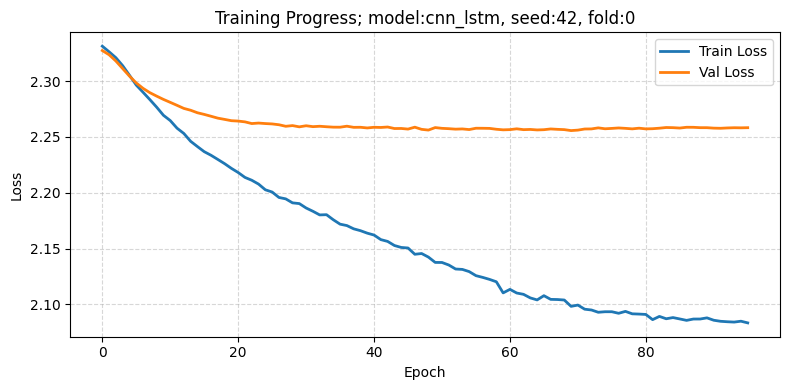

Processing model:cnn_lstm, seed:42, fold:1


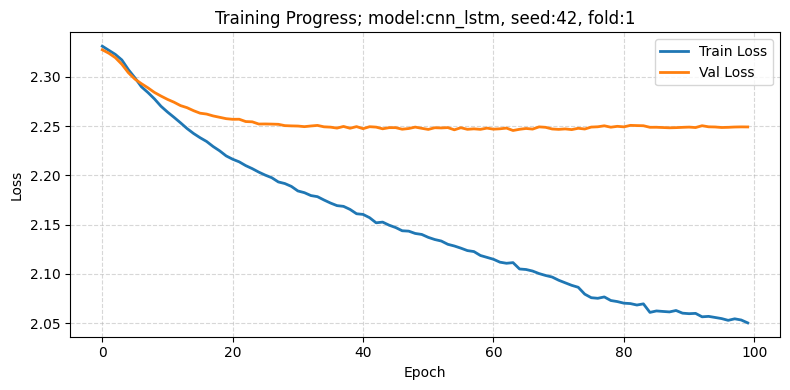

Processing model:cnn_lstm, seed:42, fold:2


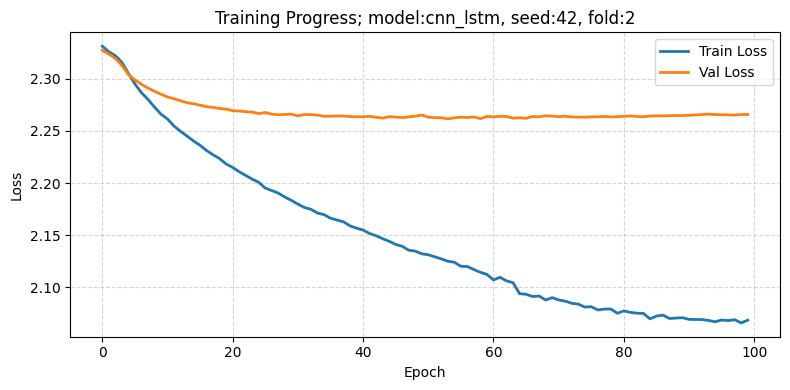

Processing model:cnn_lstm, seed:140, fold:0


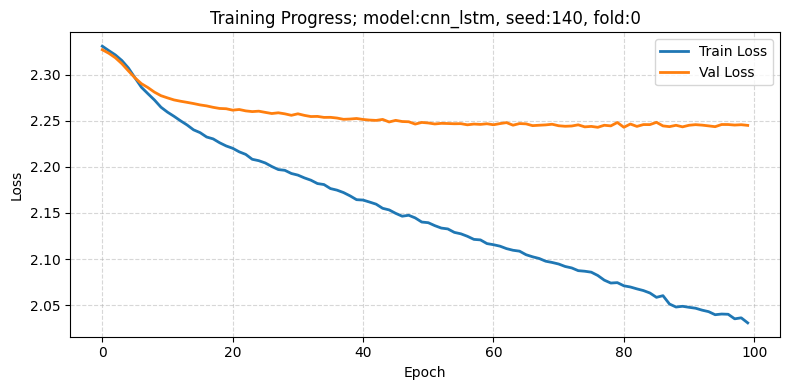

Processing model:cnn_lstm, seed:140, fold:1


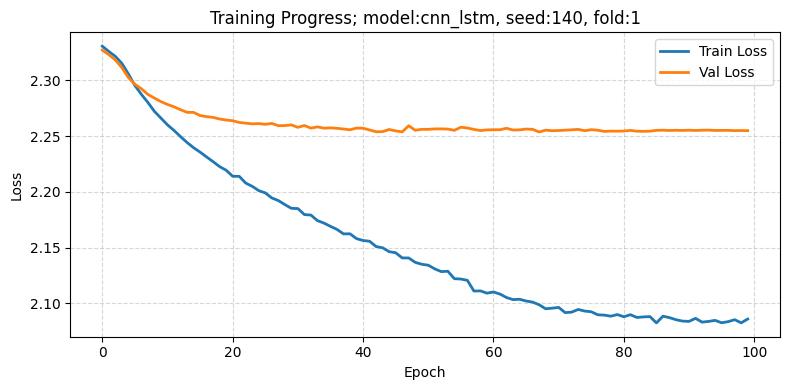

Processing model:cnn_lstm, seed:140, fold:2


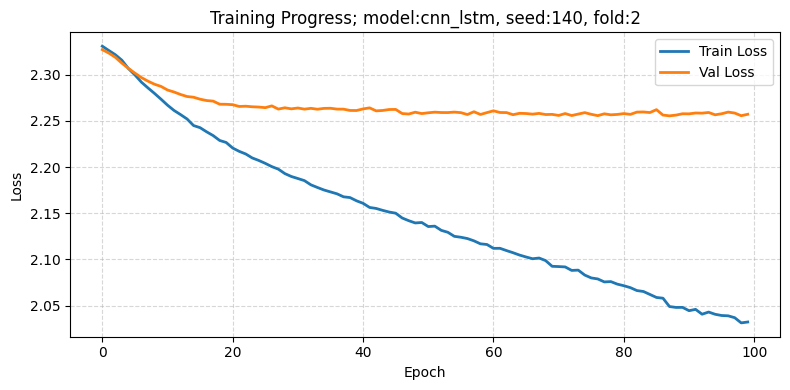

Processing model:cnn_lstm, seed:2025, fold:0


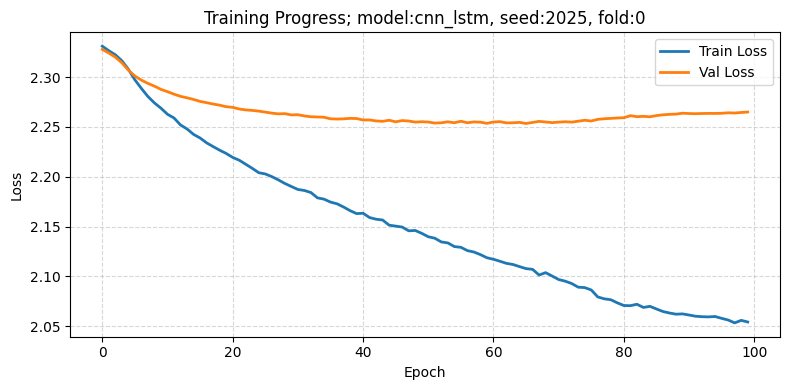

Processing model:cnn_lstm, seed:2025, fold:1


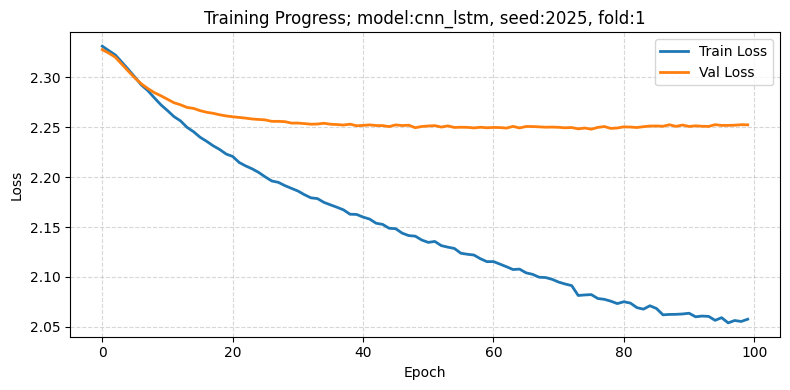

Processing model:cnn_lstm, seed:2025, fold:2


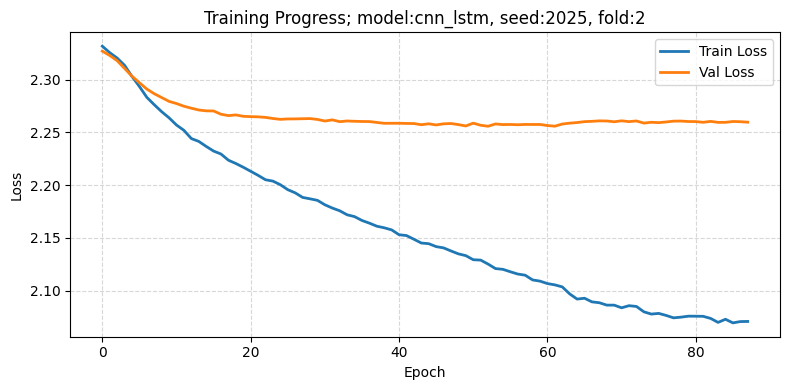

Processing model:transformer_encoder, seed:42, fold:0


I0000 00:00:1753771045.802219     102 service.cc:148] XLA service 0x5658afc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753771045.808057     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753771045.808081     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753771050.487697     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


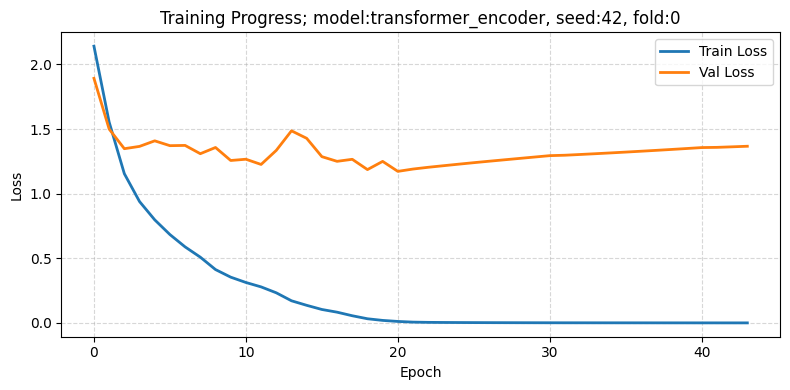

Processing model:transformer_encoder, seed:42, fold:1


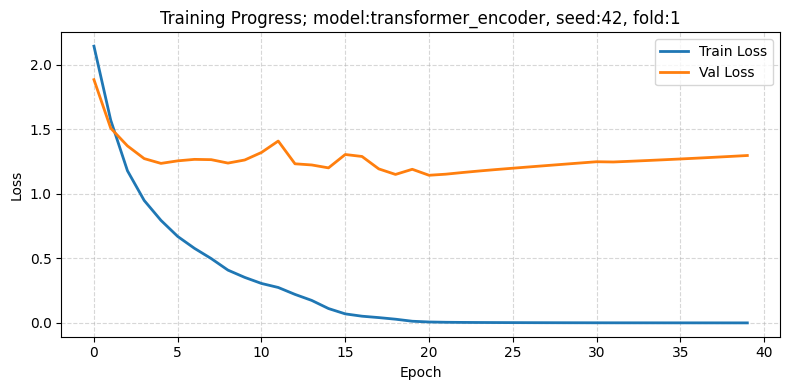

Processing model:transformer_encoder, seed:42, fold:2


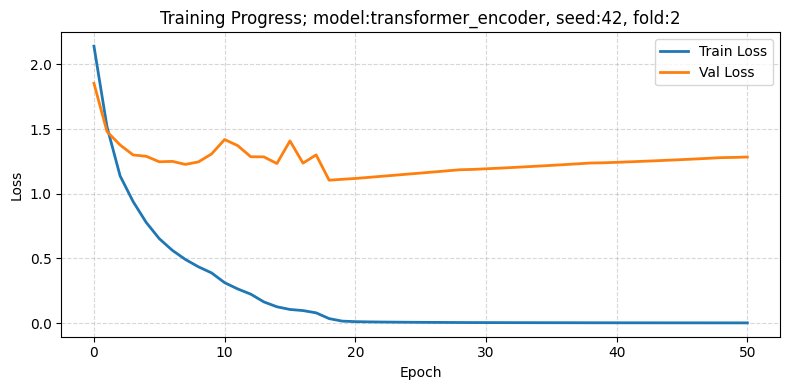

Processing model:transformer_encoder, seed:140, fold:0


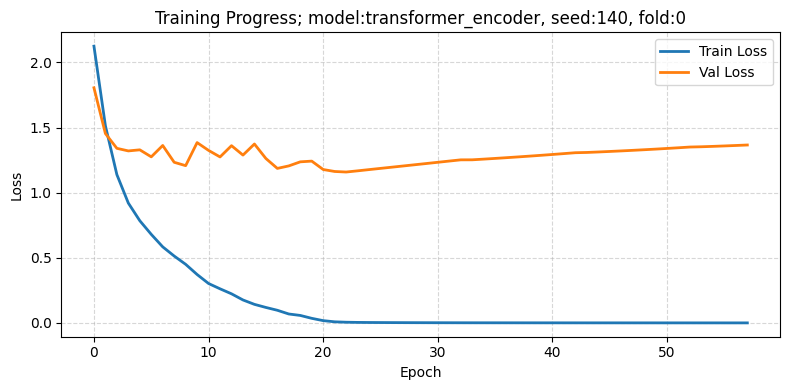

Processing model:transformer_encoder, seed:140, fold:1


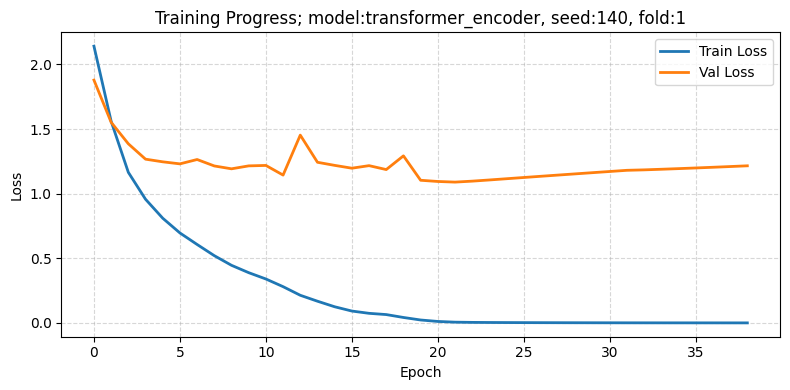

Processing model:transformer_encoder, seed:140, fold:2


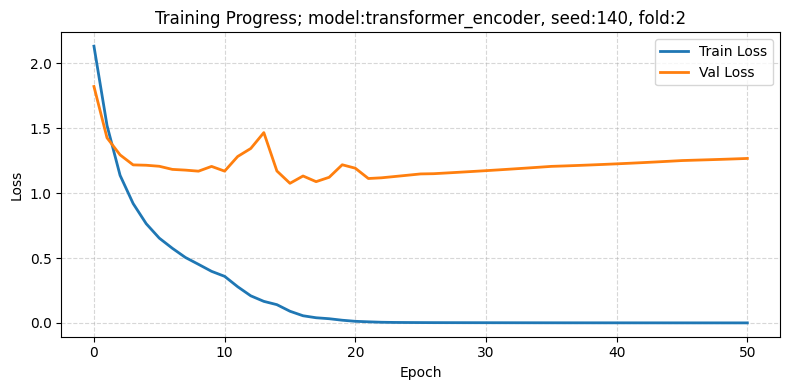

Processing model:transformer_encoder, seed:2025, fold:0


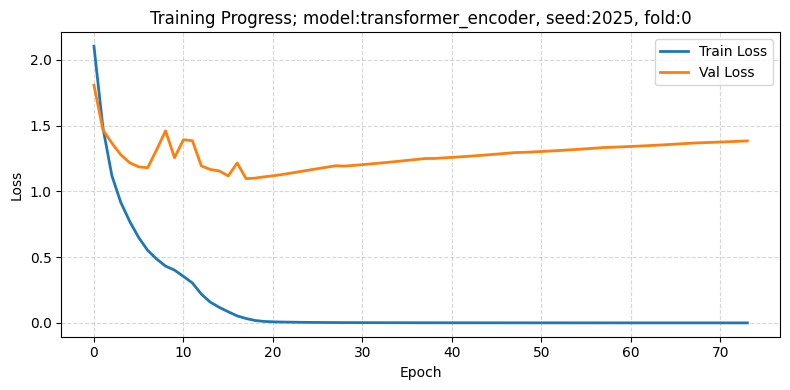

Processing model:transformer_encoder, seed:2025, fold:1


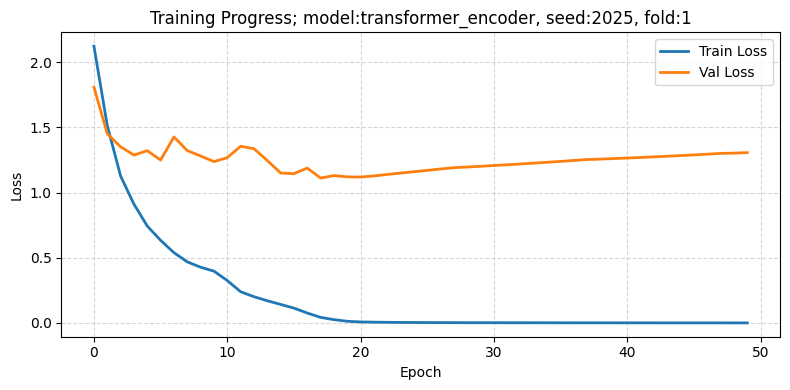

Processing model:transformer_encoder, seed:2025, fold:2


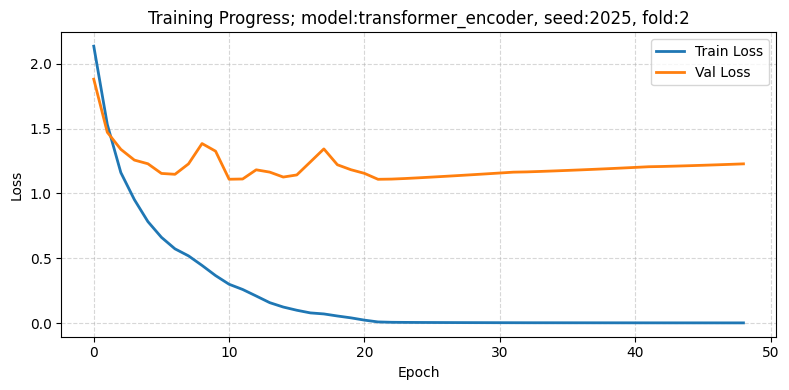

Processing model:lstm_attention, seed:42, fold:0


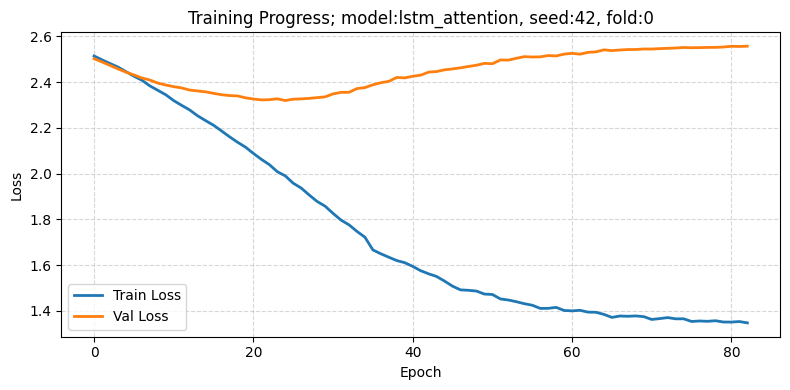

Processing model:lstm_attention, seed:42, fold:1


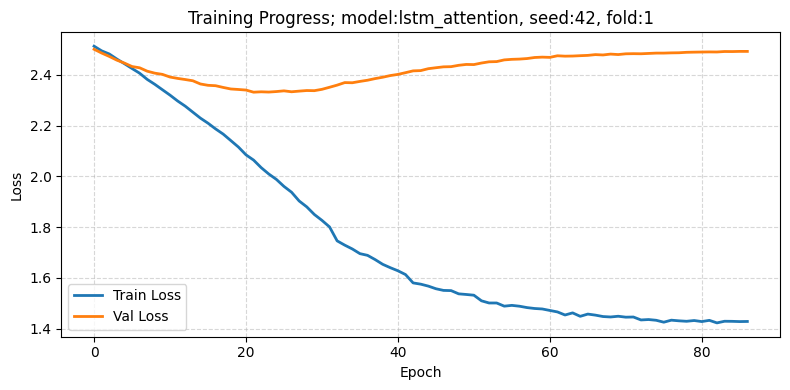

Processing model:lstm_attention, seed:42, fold:2


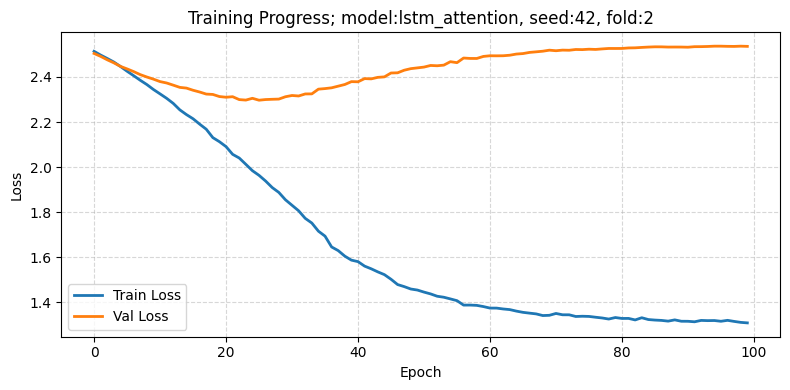

Processing model:lstm_attention, seed:140, fold:0


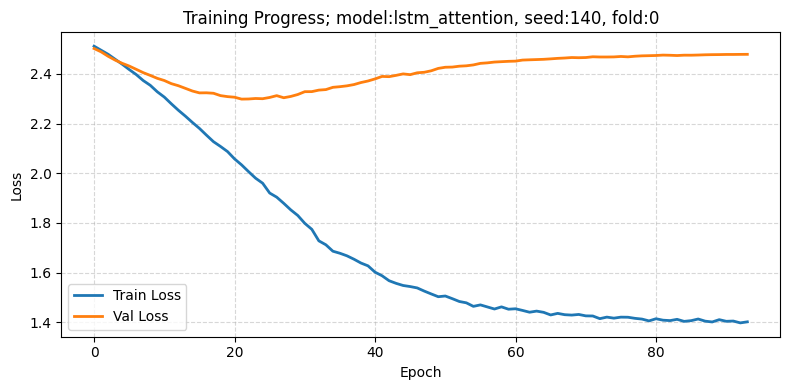

Processing model:lstm_attention, seed:140, fold:1


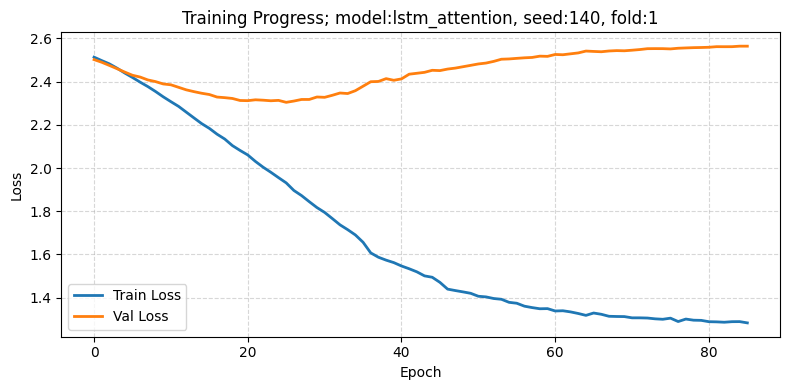

Processing model:lstm_attention, seed:140, fold:2


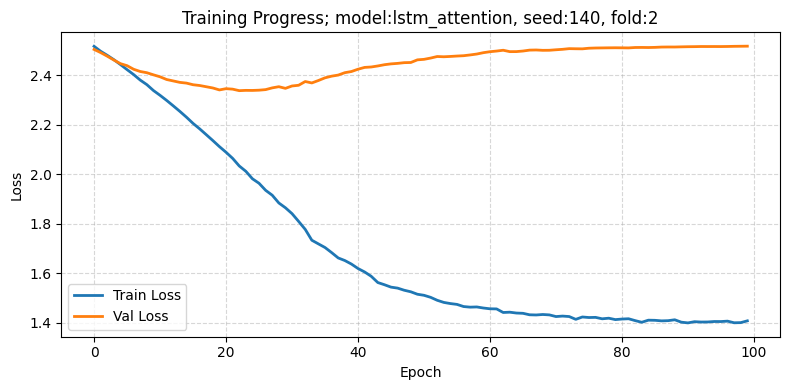

Processing model:lstm_attention, seed:2025, fold:0


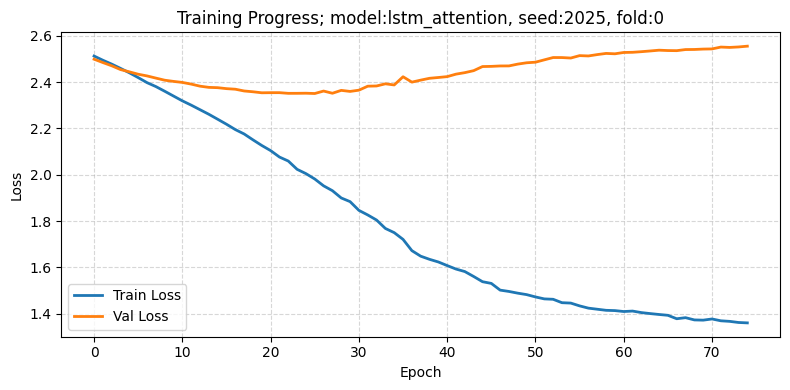

Processing model:lstm_attention, seed:2025, fold:1


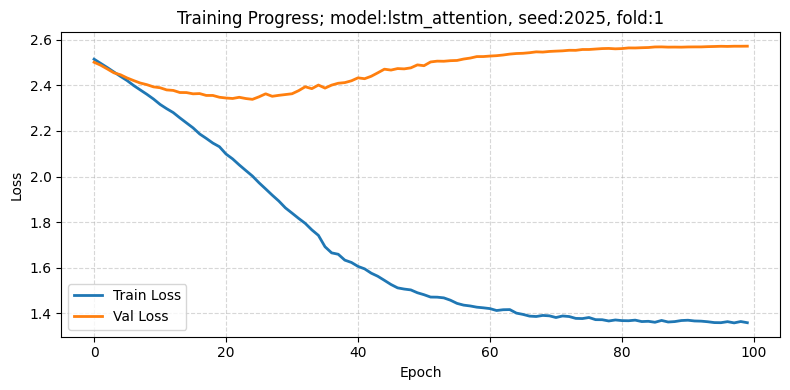

Processing model:lstm_attention, seed:2025, fold:2


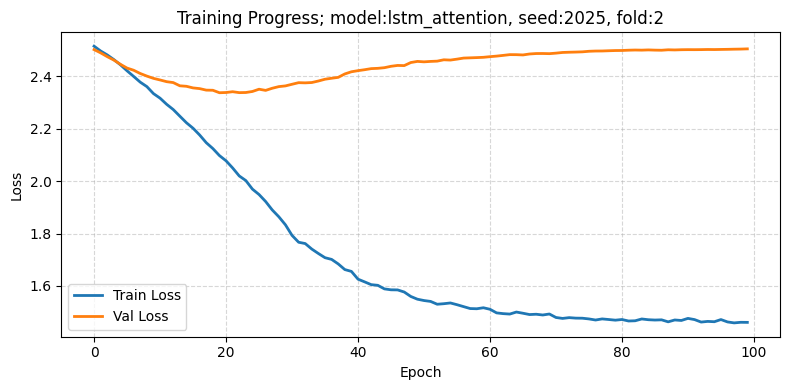

EXPERIMENT FINISHED.


In [18]:
import pandas as pd
pd.DataFrame(results).to_csv("experiment_results.csv", index=False)

## **EVALUATION**

In [27]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# --- Load Data ---
df = pd.read_csv('/kaggle/input/fec-experiment-results/experiment_results.csv')

recap = []

# --- Loop every model and fold ---
for model in df['model'].unique():
    for fold in df['fold'].unique():
        # Filter
        subset = df[(df['model'] == model) & (df['fold'] == fold)]
        
        if len(subset) == 0:
            continue
        
        # best_loss and acc_at_best_loss
        avg_loss = subset['best_loss'].mean()
        avg_acc  = subset['acc_at_best_loss'].mean()
        
        recap.append({
            'model': model,
            'fold': fold + 1,
            'mean_acc': round(avg_acc, 4),
            'mean_loss': round(avg_loss, 4)
        })

# --- Convert to DataFrame ---
recap_df = pd.DataFrame(recap)
print(tabulate(recap_df, headers='keys', tablefmt='grid'))

# --- Mean PER MODEL ---
summary = recap_df.groupby('model')[['mean_acc', 'mean_loss']].mean().reset_index()
print("\n=== MEAN OF 3 FOLDS PER MODEL ===")
print(tabulate(summary, headers='keys', tablefmt='grid'))

+----+---------------------+--------+------------+-------------+
|    | model               |   fold |   mean_acc |   mean_loss |
+====+=====================+========+============+=============+
|  0 | ann_mlp             |      1 |     0.7666 |      1.3732 |
+----+---------------------+--------+------------+-------------+
|  1 | ann_mlp             |      2 |     0.7747 |      1.3326 |
+----+---------------------+--------+------------+-------------+
|  2 | ann_mlp             |      3 |     0.7716 |      1.3413 |
+----+---------------------+--------+------------+-------------+
|  3 | cnn                 |      1 |     0.2261 |      2.1925 |
+----+---------------------+--------+------------+-------------+
|  4 | cnn                 |      2 |     0.2285 |      2.1811 |
+----+---------------------+--------+------------+-------------+
|  5 | cnn                 |      3 |     0.2278 |      2.1887 |
+----+---------------------+--------+------------+-------------+
|  6 | lstm              

In [1]:
import pandas as pd
from scipy.stats import wilcoxon

# Muat data hasil eksperimen
df = pd.read_csv('/kaggle/input/fec-experiment-results/experiment_results.csv')

# Ambil data untuk model LSTM+Attention
df_lstm_att = df[df['model'] == 'lstm_attention']

# Model-model pembanding
baselines = ['ann_mlp', 'cnn', 'lstm', 'bilstm', 'cnn_lstm', 'transformer_encoder']

In [3]:
for baseline in baselines:
    df_base = df[df['model'] == baseline]
    
    # Pastikan fold-nya cocok urutannya
    df_lstm_att_sorted = df_lstm_att.sort_values(by=['fold', 'seed'])
    df_base_sorted     = df_base.sort_values(by=['fold', 'seed'])

    acc_lstm = df_lstm_att_sorted['acc_at_best_loss'].values
    acc_base = df_base_sorted['acc_at_best_loss'].values

    loss_lstm = df_lstm_att_sorted['best_loss'].values
    loss_base = df_base_sorted['best_loss'].values

    # Wilcoxon untuk akurasi (greater)
    stat_acc, p_acc = wilcoxon(acc_lstm, acc_base, alternative='greater')

    # Wilcoxon untuk loss (less)
    stat_loss, p_loss = wilcoxon(loss_lstm, loss_base, alternative='less')

    print(f"--- Comparison: LSTM+Attention vs {baseline.upper()} ---")
    print(f"Akurasi - Wilcoxon stat={stat_acc:.4f}, p-value={p_acc:.4f} (H1: LSTM+Att > {baseline})")
    print(f"Loss    - Wilcoxon stat={stat_loss:.4f}, p-value={p_loss:.4f} (H1: LSTM+Att < {baseline})")
    print()

--- Comparison: LSTM+Attention vs ANN_MLP ---
Akurasi - Wilcoxon stat=0.0000, p-value=1.0000 (H1: LSTM+Att > ann_mlp)
Loss    - Wilcoxon stat=45.0000, p-value=1.0000 (H1: LSTM+Att < ann_mlp)

--- Comparison: LSTM+Attention vs CNN ---
Akurasi - Wilcoxon stat=41.0000, p-value=0.0137 (H1: LSTM+Att > cnn)
Loss    - Wilcoxon stat=45.0000, p-value=1.0000 (H1: LSTM+Att < cnn)

--- Comparison: LSTM+Attention vs LSTM ---
Akurasi - Wilcoxon stat=0.0000, p-value=1.0000 (H1: LSTM+Att > lstm)
Loss    - Wilcoxon stat=45.0000, p-value=1.0000 (H1: LSTM+Att < lstm)

--- Comparison: LSTM+Attention vs BILSTM ---
Akurasi - Wilcoxon stat=1.0000, p-value=0.9980 (H1: LSTM+Att > bilstm)
Loss    - Wilcoxon stat=45.0000, p-value=1.0000 (H1: LSTM+Att < bilstm)

--- Comparison: LSTM+Attention vs CNN_LSTM ---
Akurasi - Wilcoxon stat=45.0000, p-value=0.0020 (H1: LSTM+Att > cnn_lstm)
Loss    - Wilcoxon stat=45.0000, p-value=1.0000 (H1: LSTM+Att < cnn_lstm)

--- Comparison: LSTM+Attention vs TRANSFORMER_ENCODER ---
A